## Problem statement: 
To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

## Step 1 : Importing Packages

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.regularizers import l2
import shutil
import sys

## Step 2 : Importing Data and Understanding Data

- Number of Images
- Classes

In [2]:
# Defining the path for train and test images

path_to_training_dataset = "./Train"
path_to_test_dataset = "./Test"
path_to_training_dataset = os.path.abspath(path_to_training_dataset) + "/"
path_to_test_dataset = os.path.abspath(path_to_test_dataset) + "/"
data_dir_train = pathlib.Path(path_to_training_dataset)
data_dir_test = pathlib.Path(path_to_test_dataset)

In [3]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print("Number of Images in Training Set:",image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print("Number of Images in Testing Set:",image_count_test)

Number of Images in Training Set: 2239
Number of Images in Testing Set: 118


## Step 3 : Data Preprocessing

### Creating the Datasets

- Input Shape
- Batch Size
- Training Data Loader
- Validation Data Loader

In [4]:
batch_size = 32
img_height = 180
img_width = 180

In [5]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [6]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [7]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualizing the Data

- Visualize one instance of all the nine classes present in the dataset 

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
### your code goes here, you can use training or validation data to visualize

for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

from tensorflow.keras import layers

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

normalized_train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_train_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

### Configure the dataset for performance

Let's make sure to use buffered prefetching so we can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data.

.cache() keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

.prefetch() overlaps data preprocessing and model execution while training.

In [1]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

NameError: name 'tf' is not defined

## Step 4: Modelling

- Model 1: Vanilla Model
- Model 2: Vanilla Model + Dropout Layer + Data Augmentation (to counter overfitting)
- Model 3: Vanilla Model + Dropout Layer + Data Augmentation (to counter overfitting) + Class Balanced Dataset

### Model 1: Vanilla Model

In [10]:
## Vanilla Model 
## Rescaling to normalize pixel values between (0,1). 
## The RGB channel values are in the [0, 255] range. This is not ideal for a neural network. Here, it is good to standardize values to be in the [0, 1]

num_classes = 9

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)), # standardize values to be in the [0, 1]
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(64, activation='relu'),
  layers.Dense(num_classes)
])

#### Choosing Optimizer and Loss Function

Adam optimization is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.

According to [Kingma et al., 2014](https://arxiv.org/abs/1412.6980), the method is "computationally efficient, has little memory requirement, invariant to diagonal rescaling of gradients, and is well suited for problems that are large in terms of data/parameters".

Sparse Cross Entropy Computes the crossentropy loss between the labels and predictions.

We use this crossentropy loss function when there are two or more label classes. We expect labels to be provided as integers. If we want to provide labels using one-hot representation, we use CategoricalCrossentropy loss.

In [11]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [12]:
epochs = 20

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  verbose=True
)

Epoch 1/20
56/56 [==============================] - 38s 482ms/step - loss: 2.1194 - accuracy: 0.2099 - val_loss: 1.7670 - val_accuracy: 0.3803
Epoch 2/20
56/56 [==============================] - 25s 444ms/step - loss: 1.7148 - accuracy: 0.3887 - val_loss: 1.6194 - val_accuracy: 0.4541
Epoch 3/20
56/56 [==============================] - 25s 448ms/step - loss: 1.5535 - accuracy: 0.4642 - val_loss: 1.6386 - val_accuracy: 0.4183
Epoch 4/20
56/56 [==============================] - 25s 449ms/step - loss: 1.3993 - accuracy: 0.5159 - val_loss: 1.4042 - val_accuracy: 0.5369
Epoch 5/20
56/56 [==============================] - 26s 468ms/step - loss: 1.2754 - accuracy: 0.5700 - val_loss: 1.3284 - val_accuracy: 0.5570
Epoch 6/20
56/56 [==============================] - 24s 432ms/step - loss: 1.2002 - accuracy: 0.5836 - val_loss: 1.4752 - val_accuracy: 0.5213
Epoch 7/20
56/56 [==============================] - 26s 470ms/step - loss: 1.1558 - accuracy: 0.5853 - val_loss: 1.4232 - val_accuracy: 0.5101

### Analysis

As you can see from the plots, training accuracy and validation accuracy are off by large margin and the model has achieved only around 50% accuracy on the validation set.

Let's look at what went wrong and try to increase the overall performance of the model.


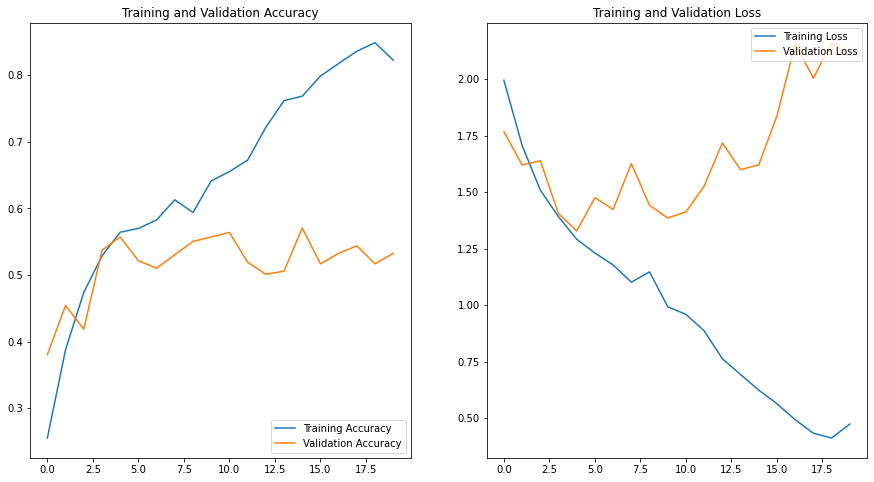

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### **Overfitting**

In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 50% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable—a sign of overfitting.

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight overfitting in the training process. we'll use data augmentation and add Dropout to our model.

### Data augmentation

Overfitting generally occurs when there are a small number of training examples. Data augmentation takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

In [14]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

### Visualize how your augmentation strategy works for one instance of training image.

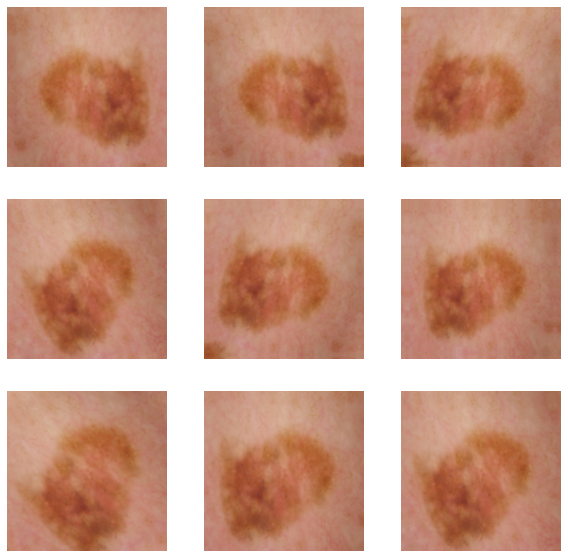

In [15]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Dropout

Another technique to reduce overfitting is to introduce Dropout to the network, a form of regularization.

When you apply Dropout to a layer it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

Let's create a new neural network using layers.Dropout, then train it using augmented images.

### Model 2 : Vanilla Model + Dropout Layers + Data Augmenting (to counter Overfitting)

In [16]:
# Vanilla Model + Dropout Layers + Data Augmenting (to counter Overfitting)

num_classes = 9

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(64, activation='relu'), 
  layers.Dense(num_classes)
])

In [17]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  verbose=True
)

Epoch 1/20
56/56 [==============================] - 30s 534ms/step - loss: 2.1546 - accuracy: 0.1797 - val_loss: 1.9385 - val_accuracy: 0.3199
Epoch 2/20
56/56 [==============================] - 31s 559ms/step - loss: 1.9541 - accuracy: 0.2765 - val_loss: 1.8148 - val_accuracy: 0.3199
Epoch 3/20
56/56 [==============================] - 28s 507ms/step - loss: 1.7236 - accuracy: 0.3631 - val_loss: 1.5608 - val_accuracy: 0.4385
Epoch 4/20
56/56 [==============================] - 29s 525ms/step - loss: 1.6037 - accuracy: 0.4451 - val_loss: 1.5084 - val_accuracy: 0.4743
Epoch 5/20
56/56 [==============================] - 32s 564ms/step - loss: 1.5050 - accuracy: 0.4739 - val_loss: 1.6467 - val_accuracy: 0.3915
Epoch 6/20
56/56 [==============================] - 31s 551ms/step - loss: 1.5128 - accuracy: 0.4565 - val_loss: 1.4147 - val_accuracy: 0.5168
Epoch 7/20
56/56 [==============================] - 30s 541ms/step - loss: 1.4187 - accuracy: 0.4922 - val_loss: 1.3934 - val_accuracy: 0.5145

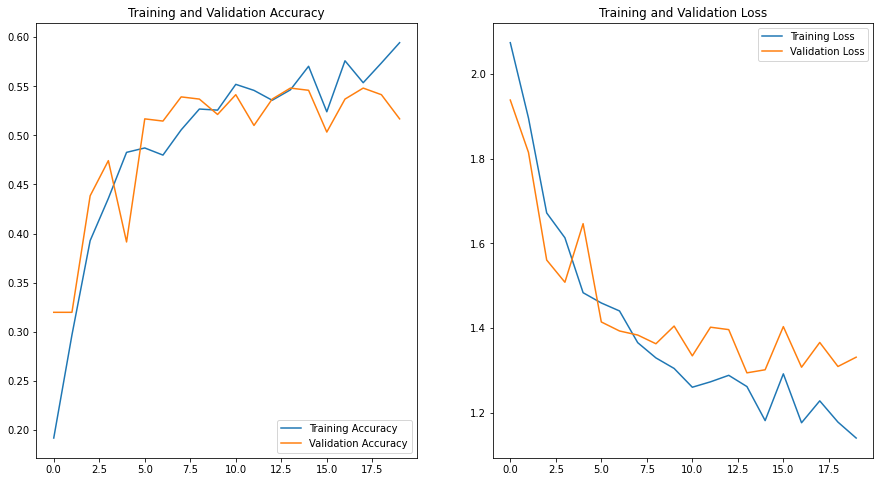

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Overfitting Resolved - But Model is Underfitting

As we can see, the overfitting issue is resolved as training accuracy and validation accuracy are not far away from each other.

But, still the accuracy is around 50-60%, which means the model is **Underfitting**, let us see how we can increase accuracy by having a closer look at the dataset

#### Distribution of Classes in the Training Dataset.

/home/ashai/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


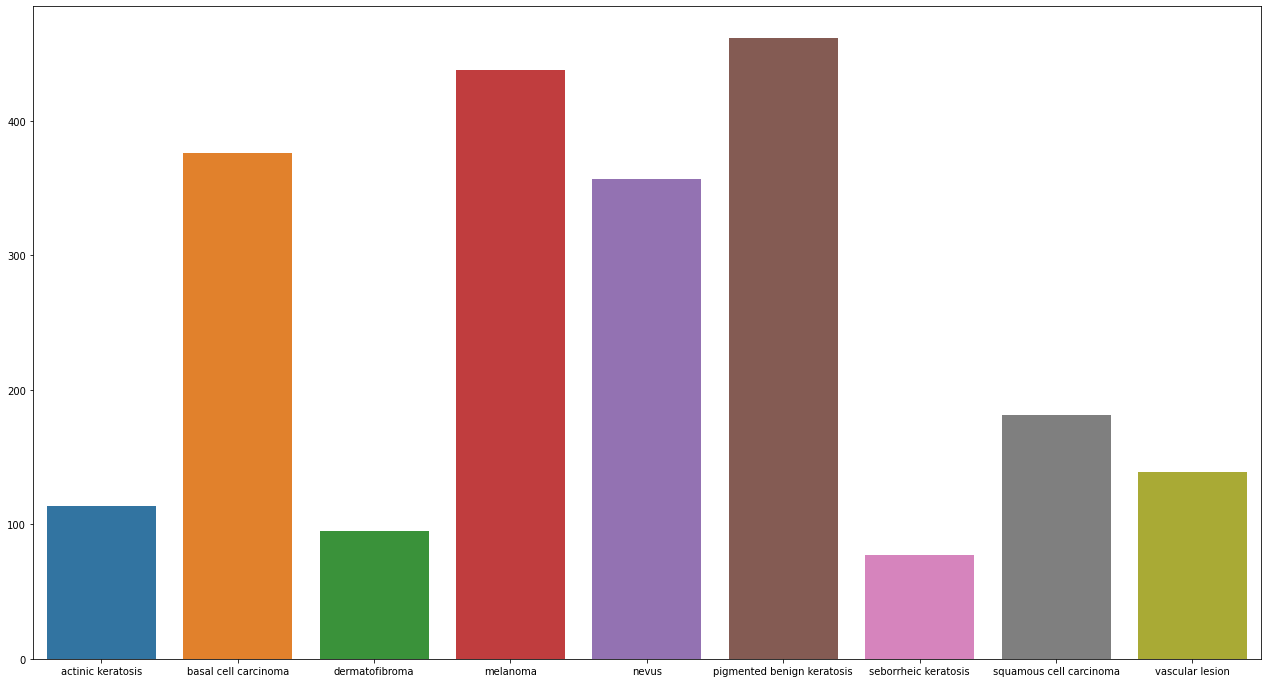

In [20]:
class_dict_orig = {}
for i in class_names:
    class_path = pathlib.Path(path_to_training_dataset + i)
    class_count = len(list(class_path.glob('*.jpg')))
    class_dict_orig[i] = class_count

import seaborn as sns
fig, ax = plt.subplots(figsize=(22,12))
sns.barplot(list(class_dict_orig.keys()), list(class_dict_orig.values()))
plt.show()

In [21]:
pd.DataFrame(list(class_dict_orig.items()),columns = ["Class Names","Number of Images"]).sort_values(by=["Number of Images"])

,Class Names,Number of Images
6,seborrheic keratosis,77
2,dermatofibroma,95
0,actinic keratosis,114
8,vascular lesion,139
7,squamous cell carcinoma,181
4,nevus,357
1,basal cell carcinoma,376
3,melanoma,438
5,pigmented benign keratosis,462


### Class Imbalance

<br>

**Class with lowest Data is "seborrheic keratosis" with 77 images**

**Class with Highest Data is "pigmented benign keratosis" with 462 Images**

So, to get more data, we just need to make minor alterations to our existing dataset. Minor changes such as flips or translations or rotations. Our neural network would think these are distinct images anyway.

A convolutional neural network that can robustly classify objects even if its placed in different orientations is said to have the property called invariance. More specifically, a CNN can be invariant to translation, viewpoint, size or illumination (Or a combination of the above).

This essentially is the premise of data augmentation. In the real world scenario, we may have a dataset of images taken in a limited set of conditions. But, our target application may exist in a variety of conditions, such as different orientation, location, scale, brightness etc. We account for these situations by training our neural network with additional synthetically modified data.

### Rectify the Class Imbalance

#### Augmentor - Data Augmentation Package

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [22]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install Augmentor

In [23]:

import Augmentor
train_base_dir = path_to_training_dataset.split('Train')[0]
new_train_dir = train_base_dir + "Train_class_balanced/"
shutil.copytree(path_to_training_dataset,new_train_dir)
for i in class_names:
    print(path_to_training_dataset + i)
    p = Augmentor.Pipeline(path_to_training_dataset + i, new_train_dir+i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EFE1493B250>:   1%|▏         | 7/500 [00:00<00:35, 13.74 Samples/s]                  

/home/ashai/Downloads/Train/actinic keratosis
Initialised with 114 image(s) found.
Output directory set to /home/ashai/Downloads/Train_class_balanced/actinic keratosis.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EFE1482DE80>: 100%|██████████| 500/500 [00:04<00:00, 101.35 Samples/s]                  
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

/home/ashai/Downloads/Train/basal cell carcinoma
Initialised with 376 image(s) found.
Output directory set to /home/ashai/Downloads/Train_class_balanced/basal cell carcinoma.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7EFD30707700>: 100%|██████████| 500/500 [00:04<00:00, 116.21 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

/home/ashai/Downloads/Train/dermatofibroma
Initialised with 95 image(s) found.
Output directory set to /home/ashai/Downloads/Train_class_balanced/dermatofibroma.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7EFC9FBDFA90>: 100%|██████████| 500/500 [00:04<00:00, 105.22 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7EFD95F4FB80>:   0%|          | 0/500 [00:00<?, ? Samples/s]

/home/ashai/Downloads/Train/melanoma
Initialised with 438 image(s) found.
Output directory set to /home/ashai/Downloads/Train_class_balanced/melanoma.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7EFD440B7BE0>: 100%|██████████| 500/500 [00:25<00:00, 19.91 Samples/s]                   
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

/home/ashai/Downloads/Train/nevus
Initialised with 357 image(s) found.
Output directory set to /home/ashai/Downloads/Train_class_balanced/nevus.

Processing <PIL.Image.Image image mode=RGB size=1504x1129 at 0x7EFD30738E50>: 100%|██████████| 500/500 [00:23<00:00, 21.71 Samples/s]                  
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EFD6C2EDA00>:   2%|▏         | 11/500 [00:00<00:07, 64.41 Samples/s]                 

/home/ashai/Downloads/Train/pigmented benign keratosis
Initialised with 462 image(s) found.
Output directory set to /home/ashai/Downloads/Train_class_balanced/pigmented benign keratosis.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EFE149626D0>: 100%|██████████| 500/500 [00:04<00:00, 115.01 Samples/s]                  
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7EFD307071C0>:   0%|          | 0/500 [00:00<?, ? Samples/s]

/home/ashai/Downloads/Train/seborrheic keratosis
Initialised with 77 image(s) found.
Output directory set to /home/ashai/Downloads/Train_class_balanced/seborrheic keratosis.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7EFD30738E50>: 100%|██████████| 500/500 [00:10<00:00, 48.20 Samples/s]                  
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7EFD44208040>:   2%|▏         | 8/500 [00:00<00:26, 18.46 Samples/s]

/home/ashai/Downloads/Train/squamous cell carcinoma
Initialised with 181 image(s) found.
Output directory set to /home/ashai/Downloads/Train_class_balanced/squamous cell carcinoma.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7EFD6C31D9D0>: 100%|██████████| 500/500 [00:05<00:00, 99.83 Samples/s] 
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EFD6C38E1F0>:   0%|          | 0/500 [00:00<?, ? Samples/s]

/home/ashai/Downloads/Train/vascular lesion
Initialised with 139 image(s) found.
Output directory set to /home/ashai/Downloads/Train_class_balanced/vascular lesion.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EFD441942B0>: 100%|██████████| 500/500 [00:04<00:00, 107.19 Samples/s]                  


### Lets see the distribution of augmented data after adding new images to the original training data.

/home/ashai/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


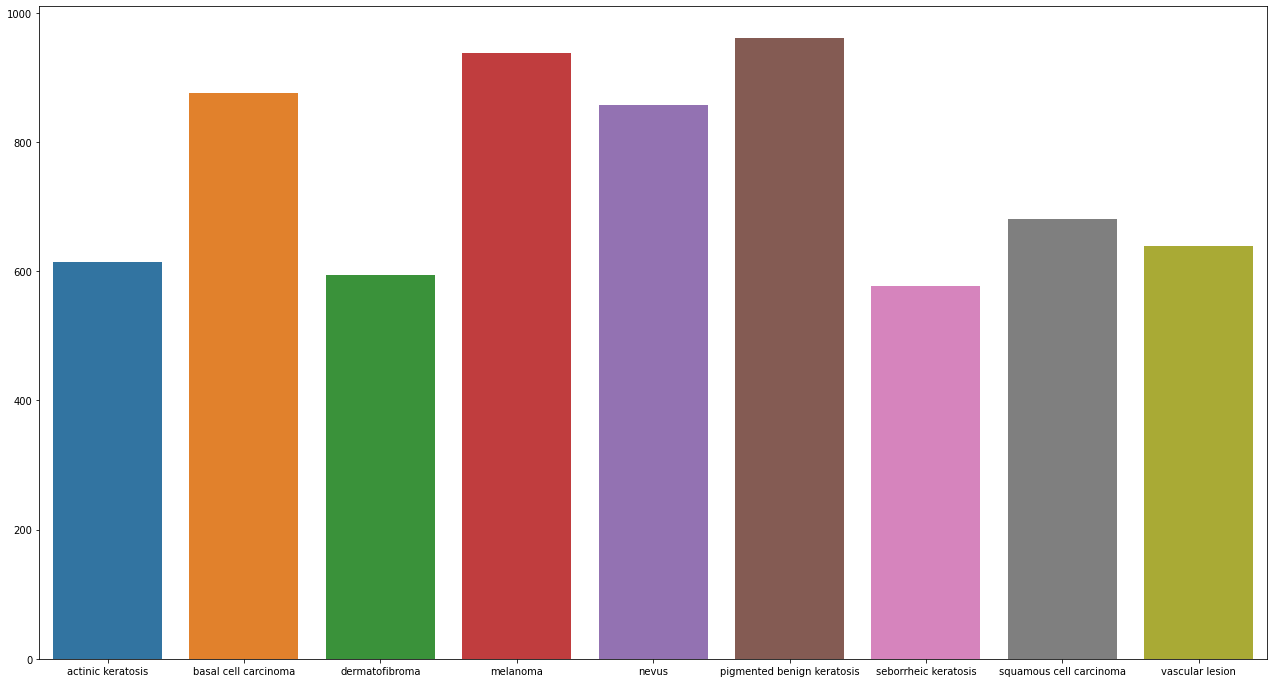

In [24]:
class_dict_new = {}
for i in class_names:
    class_path = pathlib.Path(new_train_dir + i)
    class_count = len(list(class_path.glob('*.jpg')))
    class_dict_new[i] = class_count

import seaborn as sns
fig, ax = plt.subplots(figsize=(22,12))
sns.barplot(list(class_dict_new.keys()), list(class_dict_new.values()))
plt.show()

In [25]:
pd.DataFrame(list(class_dict_new.items()),columns = ["Class Names","Number of Images"]).sort_values(by=["Number of Images"])

,Class Names,Number of Images
6,seborrheic keratosis,577
2,dermatofibroma,595
0,actinic keratosis,614
8,vascular lesion,639
7,squamous cell carcinoma,681
4,nevus,857
1,basal cell carcinoma,876
3,melanoma,938
5,pigmented benign keratosis,962


#### Class Imbalance is Rectified - All Classes have a minimum of 500 Images

### Model 3 : Vanilla Model + Dropout Layer + Data Augmentation (to counter overfitting) + Class Imbalance (to counter class imbalance) <br>

- Creating New Augmented Train Loader
- Creating New Augmented Validation Loader
- Train for 50 Epochs as data increased

In [26]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  new_train_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [27]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  new_train_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [28]:
# Vanilla Model + Dropout Layers + Data Augmentation + Class balanced Dataset

num_classes = 9

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(64, activation='relu'), 
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
    verbose=True
)

Epoch 1/50
169/169 [==============================] - 105s 612ms/step - loss: 1.9696 - accuracy: 0.2475 - val_loss: 1.6091 - val_accuracy: 0.3734
Epoch 2/50
169/169 [==============================] - 103s 607ms/step - loss: 1.5144 - accuracy: 0.4220 - val_loss: 1.4894 - val_accuracy: 0.4217
Epoch 3/50
169/169 [==============================] - 102s 597ms/step - loss: 1.3753 - accuracy: 0.4723 - val_loss: 1.3687 - val_accuracy: 0.4840
Epoch 4/50
169/169 [==============================] - 102s 599ms/step - loss: 1.3232 - accuracy: 0.5023 - val_loss: 1.3458 - val_accuracy: 0.4952
Epoch 5/50
169/169 [==============================] - 103s 608ms/step - loss: 1.2623 - accuracy: 0.5247 - val_loss: 1.2256 - val_accuracy: 0.5301
Epoch 6/50
169/169 [==============================] - 107s 626ms/step - loss: 1.1946 - accuracy: 0.5546 - val_loss: 1.1820 - val_accuracy: 0.5323
Epoch 7/50
169/169 [==============================] - 120s 708ms/step - loss: 1.1566 - accuracy: 0.5589 - val_loss: 1.1465 -

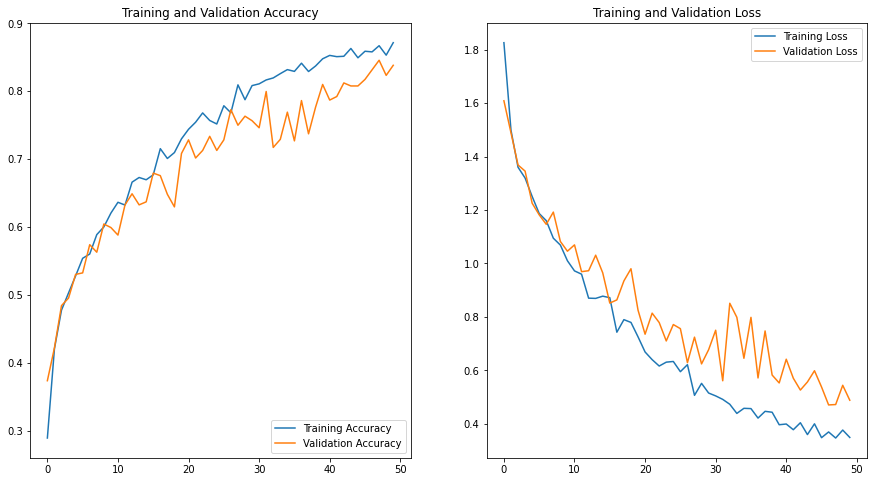

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Underfitting is Resolved

### Model 3 : Accuracy is 83% on validation and 87% on Training after running 50 epochs which is decent enough and more generalizable Model

## Step 5 : Conclusion

* Model 1: Basic Model <br>
  * Vanilla Model
  * No Dropout Layers
  * Small Dataset and No Augmentation
  * Model Training yeilded Non Accurate Model - Training accuracy 81% and Validation Accuracy 53%  
  * Model was **Overfitting** - This was due to no dropout layers and no data augmentation
<br><br>

* Model 2: Model 1 + Dropout Layers + Data Augmentation <br>
  * Dropout Layers Added
  * Data Augmentation was added
  * Gap between Training Accuracy and Validation Accuracy decreased
  * Accuracy is still low - Training Accuracy 56% and Validation Accuracy 51%
  * Model was **Underfitting** - This was due to small dataset and class imbalance dataset
<br><br>

* Model 3: Model 2 + Class balanced Dataset <br>
  * Dataset Added using Augmentor (500 images added per class) to counter class imbalance
  * Same Model 2 was used.
  * Model yeilded in 87% Training and 83% Validation Accuracy
  * This Model was both **generalizable and accurate**
